# Final Analysis

Now that we have cleaned, filtered and preprocessed our data, we can proceed to analyse it to see whether any conclusions can be drawn from the found matches.

This will be done in two parts:

First, we check whether any of the addresses, if present, of the shell companies is near the headquarter location of the charity it matches against.

Secondly, we will create graphs of all the found shell companies to analyse their distribution in the leaked papers.

__Note that in order to connect nodes to each other, both these points rest on substantial preprocessing done in the "Connections" notebook, which can be consulted for a better understanding of the structures being dealt with.__

In [1]:
#Imports
import pandas as pd

#Spark
import findspark
#findspark.init(r"C:\Users\Lucas\Desktop\ADA\spark-2.3.2-bin-hadoop2.7")
findspark.init('/opt/spark/spark-2.3.2-bin-hadoop2.7/')

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.functions import udf
from pyspark.sql.functions import split
from pyspark.sql.functions import explode

from pyspark.sql.types import StringType
from pyspark.sql.types import TimestampType

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()


#imports
import networkx as nx

from operator import itemgetter
import collections
import community
from networkx.algorithms.community.centrality import girvan_newman
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Addresses

Our goal is to find addresses connected to shell companies and see if they match the headquarters of the charity. This could be seen as a red flag that the shell company indeed represents the charity it was matched with.

In [2]:
#We can reuse the filtering functions from earlier, this time looking specifically 
#for edges of type "address" connected to nodes of type entity

def filter_edges(edges, nodes):
    '''Given a set of nodes, returns the edges connected to those nodes'''
    
    entity_ids = nodes.map(lambda r: r[0]).collect()
    
    return edges.filter(lambda r: r[0] in entity_ids or r[2] in entity_ids)

def filter_nodes(nodes, edges):
    '''Given a set of edges, return the nodes connected to those edges'''
    
    start_ids = edges.map(lambda r: r[0]).collect()
   
    end_ids = edges.map(lambda r: r[2]).collect()
    
    return nodes.rdd.filter(lambda r: r[0] in start_ids or r[0] in end_ids)

In [3]:
def get_address_matches(leak):
    '''return the match node id of first level connection with registered address '''
    
    #return the path of edges csv file
    edges = spark.read.csv('../data/'+ leak + '/*.edges.csv', header=True)
    
    #return the path of address nodes csv file
    address_nodes = spark.read.csv('../data/' + leak + '/*address.csv', header=True)
    
    #filter the edges that contain a registered address
    address_edges = edges.rdd.filter(lambda r: r[1] == 'registered_address')
    
    #get the matches 
    matches= spark.read.csv('../generated/map/connections/entity/entity_' + leak + '_matches.csv', 
                            header=True).drop('_c0')
    
    #filter the edges connected to matches
    entity_address_edges = filter_edges(address_edges, matches.rdd)
    
    #filter thes nodes linked to these edges
    leak_address = filter_nodes(address_nodes,entity_address_edges)
    

    ''' Conversion of the spark dataframe in pandas ones : '''
    
    #for the matches :
    matches_pd = pd.DataFrame(matches.collect(), 
                              columns=["node_id","ShellName","CharityName","CharityHeadquarters"])
    
    matches_pd = matches_pd[matches_pd['CharityHeadquarters'].isnull() == False]
    
    #for the nodes connected to the matches :
    address_pd = pd.DataFrame(leak_address.collect(),
                            columns = ["node_id","name","address","country_codes","countries",
                                       "sourceID","valid_until","note"])
    
    #for the edges connected to the matches :
    entity_address_edges_pd = pd.DataFrame(entity_address_edges.collect(),
                            columns = ["node_id","TYPE","END_ID","link","start_date",
                                       "end_date","sourceID","valid_until"])
    
    '''Apply 'int' type to the columns used for the merge : '''
    
    
    #rename the column adequatly for merging
    address_pd.rename(columns = {'node_id':'END_ID'}, inplace=True)
    
    #drop unusefull columns in order to avoid conflict when merging
    address_pd.drop(['note','valid_until','sourceID'],axis = 1, inplace = True)
    
    #first we merge in order to obtain correspondance between the matches and 
    #the corresponding edges with registered adress
    maches_edges = matches_pd.merge(entity_address_edges_pd, on = 'node_id')
    
    #then to node linked to these edges
    matches_nodes = maches_edges.merge(address_pd, on = 'END_ID')

    return matches_nodes

In [4]:
#We create a dataframe containing the matches and corresponding addresses
leaks = ['panama', 'paradise', 'offshore', 'bahamas']
address_dfs = {}

print('number of address pairs found:')
for leak in leaks:
    address_df = get_address_matches(leak)
    print(leak +': ' + str(len(address_df)))
    address_dfs[leak] = address_df[['ShellName', 'CharityName', 
                                    'CharityHeadquarters', 'address', 'countries']]


number of address pairs found:
panama: 0
paradise: 26
offshore: 1
bahamas: 0


In [5]:
pair_addresses = address_dfs['paradise']
pair_addresses = pair_addresses.append(address_dfs['offshore']).reset_index(drop = True)

display(pair_addresses)

,ShellName,CharityName,CharityHeadquarters,address,countries
0,The Duke Endowment,The Duke Endowment,Charlotte,"DUMAC, LLC",United States
1,THE BUSH FOUNDATION,Bush Foundation,Saint Paul,"332, MINNESOTA ST. STE E-900 ST PAUL MN 55101",None
2,Amnesty International,Amnesty International,London,99-119 Rosebery Avenue,United Kingdom
3,Memorial Sloan-Kettering Cancer Center,Memorial Sloan Kettering Cancer Center,New York,"633 Third Avenue, 4th Floor",United States
4,Goodwill Industries Captive,Goodwill Industries International,Rockville,c/o David Becker,United States
5,Mayo Clinic,Mayo Clinic,Rochester,c/o Treasury Services,United States
6,Memorial Sloan-Kettering Cancer Center,Memorial Sloan Kettering Cancer Center,New York,"405 Lexington Avenue, Third Floor",United States
7,The Nature Conservancy,Nature Conservancy,Arlington,"4245 North Fairfax Drive, Suite 100",United States
8,The Rotary Foundation of Rotary International,Rotary Foundation of Rotary International,Evanston,One Rotary Center,United States
9,World Vision International,World Vision,Federal Way,"800 W Chestnut Ave., M/#704",United States


We can see that we found 27 matches with registered addresses. We can compare these addresses to the Headquarters addresses. We know that if these addresses coincide there is a higher probability that the charity is directly implicated and not a cover.
Thus, we can directly drop the matches where the countriy is a Tax Heaven or where the corresponding Charity Headquarters is in a different place. It is the case for the matches above located in Barbados, Aruba, Bermuda, Canada, Hong Kong and Saint Kitts.

These matches are clearly shell companies that used charities names. We can also drop the matches where no address is given.

In [6]:
#We drop the matches without addresses
pair_addresses.dropna(inplace = True)

pair_addresses = pair_addresses[~ pair_addresses.address.str.contains("c/o", na = False)]

#We drop the matches where the country does not match
pair_addresses = pair_addresses[(pair_addresses.countries != 'Barbados') 
                                & (pair_addresses.countries != 'Aruba')
                                & (pair_addresses.countries != 'Bermuda')
                                & (pair_addresses.countries != 'Canada')
                                & (pair_addresses.countries != 'Hong Kong')
                                & (pair_addresses.countries != 'Saint Kitts and Nevis')].reset_index(drop = True)

display(pair_addresses)

,ShellName,CharityName,CharityHeadquarters,address,countries
0,The Duke Endowment,The Duke Endowment,Charlotte,"DUMAC, LLC",United States
1,Amnesty International,Amnesty International,London,99-119 Rosebery Avenue,United Kingdom
2,Memorial Sloan-Kettering Cancer Center,Memorial Sloan Kettering Cancer Center,New York,"633 Third Avenue, 4th Floor",United States
3,Memorial Sloan-Kettering Cancer Center,Memorial Sloan Kettering Cancer Center,New York,"405 Lexington Avenue, Third Floor",United States
4,The Nature Conservancy,Nature Conservancy,Arlington,"4245 North Fairfax Drive, Suite 100",United States
5,The Rotary Foundation of Rotary International,Rotary Foundation of Rotary International,Evanston,One Rotary Center,United States
6,World Vision International,World Vision,Federal Way,"800 W Chestnut Ave., M/#704",United States
7,Young Life,Young Life,Colorado Springs,P O Box 520,United States
8,American Cancer Society,American Cancer Society,Atlanta,225 N Michigan,United States
9,The Metropolitan Museum of Art,Metropolitan Museum of Art,New York,1000 Fifth Avenue,United States


In [73]:
pair_addresses.to_html('../results/datasets/address_matches.html')

We chose to keep the matches where the registered addresses correspond to the country of the charity headquarters.It would be  possible to imagine that a shell company resides in the same country as the charity from which they have stolen the name (for example Amnesty International in the United Kingdom).

But dropping these would have been too radical, making us miss potential matches by dropping them. Finally, we obtained 11 matches.

Among them, we can observe matches where the addresses corresponds exactly and that we can have serious thoughts about the implication of these charities, like for The Nature Conservancy or The Duke Endowment. 

From here, we could inspect manually each matches and look for potential scandal on the web or look in detail the connections of these matches below.


## Graphs

Using the previously collected data detailing how matches connect to the rest of the leaked information, we can create graphs and see the degree of interconnectivity between the matches. 

The main idea is that if we observe that some matches are connected between them by a common intermediary, two main explanations are possible. First, this intermediary can be specialized in charities. Otherwise it is higlhy probable that an intermediary usually takes charities names for its shell companies. 

When charities are connected together we can discern the two possibilities if one of the charity is known to be fake. In this case, it would be more probable than the connected charities are also shell companies. These could be checked by internet search or by using our addresses results found above.

We chose to only use degree 1, as larger degrees resulted in unmanagably large graphs. But distance 1 is quite good enough for our purposes.

In [7]:
#Global variables 

DEGREE = 1

DEGREE_FILE = '../generated/map/degree_' + str(DEGREE) +'/'

def get_graph_elem_file(elem_type, leak):
    return DEGREE_FILE + leak + '_' + elem_type + '.csv'

### Create the graphs

Note that as some of the graphs have still very many nodes, we can choose to filter these down to only those connected to more than one node (unless a node is a match -- we still want to know who is not connected to anyone), or to clusters only.

Note the special attention drawn to the "bahamas" leak, which has a slightly different schema.

In [62]:
def remove_loners(full_df, clusters_only, cluster_size=2):
    
    '''Removes nodes with fewer than 2 connections who are not matches'''
    
    node_counts = full_df['START_ID'].append(full_df['END_ID']).value_counts()

    ids_to_remove = []
        
    for index, row in full_df.iterrows():
        start_id = row['START_ID']
        end_id = row['END_ID']
        
        if clusters_only:
            if ((node_counts[start_id] < cluster_size) and (node_counts[end_id] < cluster_size)):
                ids_to_remove.append(index)
            
        else:
            if ((row['match_x'] == False and node_counts[start_id] < cluster_size)
                or (row['match_y'] == False and node_counts[end_id] < cluster_size)):
                ids_to_remove.append(index)
    
    return full_df.drop(full_df.index[ids_to_remove]).reset_index(drop = True)

def graph_leak_matches(leak, dense = False, clusters_only = False, cluster_size = 2):
    
    '''Creates graphs of matches found in a given leak'''
    
    bahamas = (leak == 'bahamas')

    node_id = '0'
    name_index = '1'

    if bahamas:
        node_id = '4' 
        name_index = '7'

    plt.rcParams["figure.figsize"] = (23,23)

    
    #Load the data
    nodes = pd.read_csv(get_graph_elem_file('nodes', leak), index_col = 0)\
                                                            .reset_index(drop = True)[[node_id, name_index, 'Match']]

    nodes.rename(columns={node_id:'node_id', name_index:'name', 'Match':'match'}, inplace = True)
    edges = pd.read_csv(get_graph_elem_file('edges', leak), index_col = 0).reset_index(drop = True)[['START_ID', 'END_ID']]

    #Format the data as a set of edges with information about the nodes
    full_df = pd.merge(nodes, edges, left_on = 'node_id', right_on = 'START_ID')
    full_df = pd.merge(full_df, nodes, left_on = 'END_ID', right_on = 'node_id').drop(['node_id_x', 'node_id_y'], axis = 1)
    
    #filter too large graphs if told so
    if dense:
        print('Size before removing loners: ' + str(len(full_df)))
        full_df = remove_loners(full_df, clusters_only, cluster_size)
        print('Size after removing loners: ' + str(len(full_df)))
    
    #create the graph
    graph = nx.from_pandas_edgelist(full_df, 'name_x', 'name_y', edge_attr = None, create_using = nx.Graph())
    
    #prepare for coloring the nodes according to if it is a match to a charity or not
    match_class_1 = full_df[['name_x', 'match_x']].rename(columns = {'name_x':'name', 'match_x':'match'})
    match_class_2 = full_df[['name_y', 'match_y']].rename(columns = {'name_y':'name', 'match_y':'match'})
    
    match_class = match_class_1.append(match_class_2).set_index('name')
    match_class = match_class[~match_class.index.duplicated(keep ='first')]
    
    match_class = match_class.reindex(graph.nodes())
    match_class['match'] = pd.Categorical(match_class['match'])
    
    print('Matches for ' + leak + ' papers: ')
    print(nx.info(graph))
    print('Yellow: "Charities" / Red: "Connectors"')
    
    #draw the graph
    nx.draw(graph, nx.spring_layout(graph, scale = 100, k = 0.3), with_labels = True, alpha = 0.7, node_size = 1500,
        node_color = match_class['match'].cat.codes, cmap = plt.cm.autumn)
    

    

### Display graphs

Matches for panama papers: 
Name: 
Type: Graph
Number of nodes: 52
Number of edges: 34
Average degree:   1.3077
Yellow: "Charities" / Red: "Connectors"


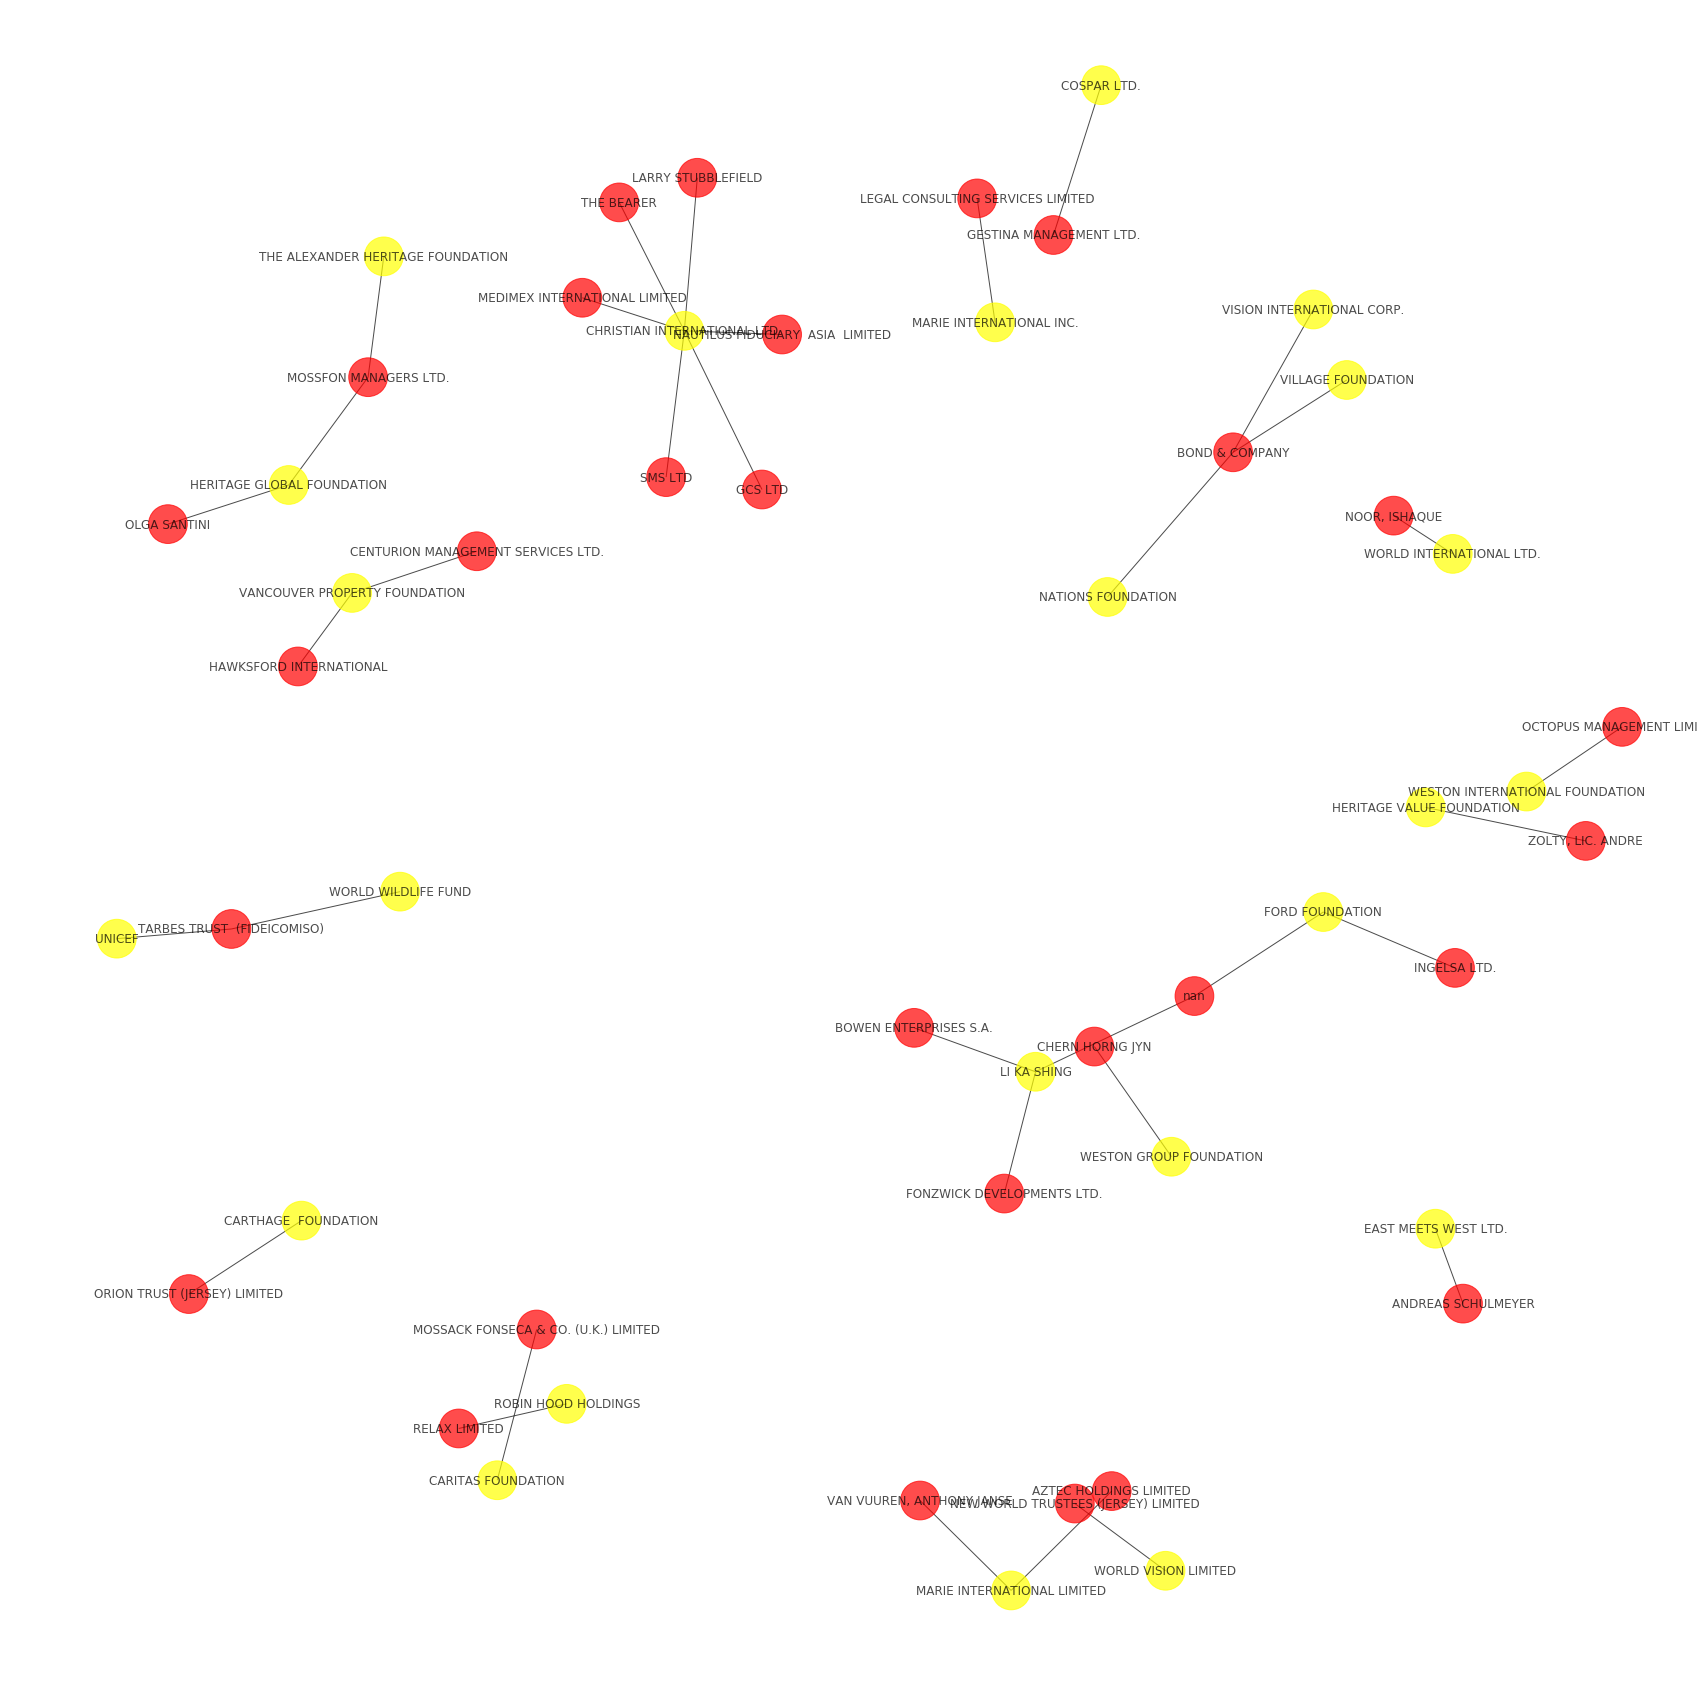

In [63]:
#Panamas
graph_leak_matches('panama')

This graph is already very interesting to look at. About half of all the charity nodes (in yellow) are somehow connected to another charity node, which is a lot for a dataset containing over 200'000 nodes. This confirms our suspicions from above that there must be intermediaries who either specialize in charities, or are in the habit of using their names. 

A closer look shows us some familiar names, such as the World Wildlife Fund and UNICEF, connected through the Tarbes Trust.

Matches for paradise papers: 
Name: 
Type: Graph
Number of nodes: 266
Number of edges: 209
Average degree:   1.5714
Yellow: "Charities" / Red: "Connectors"


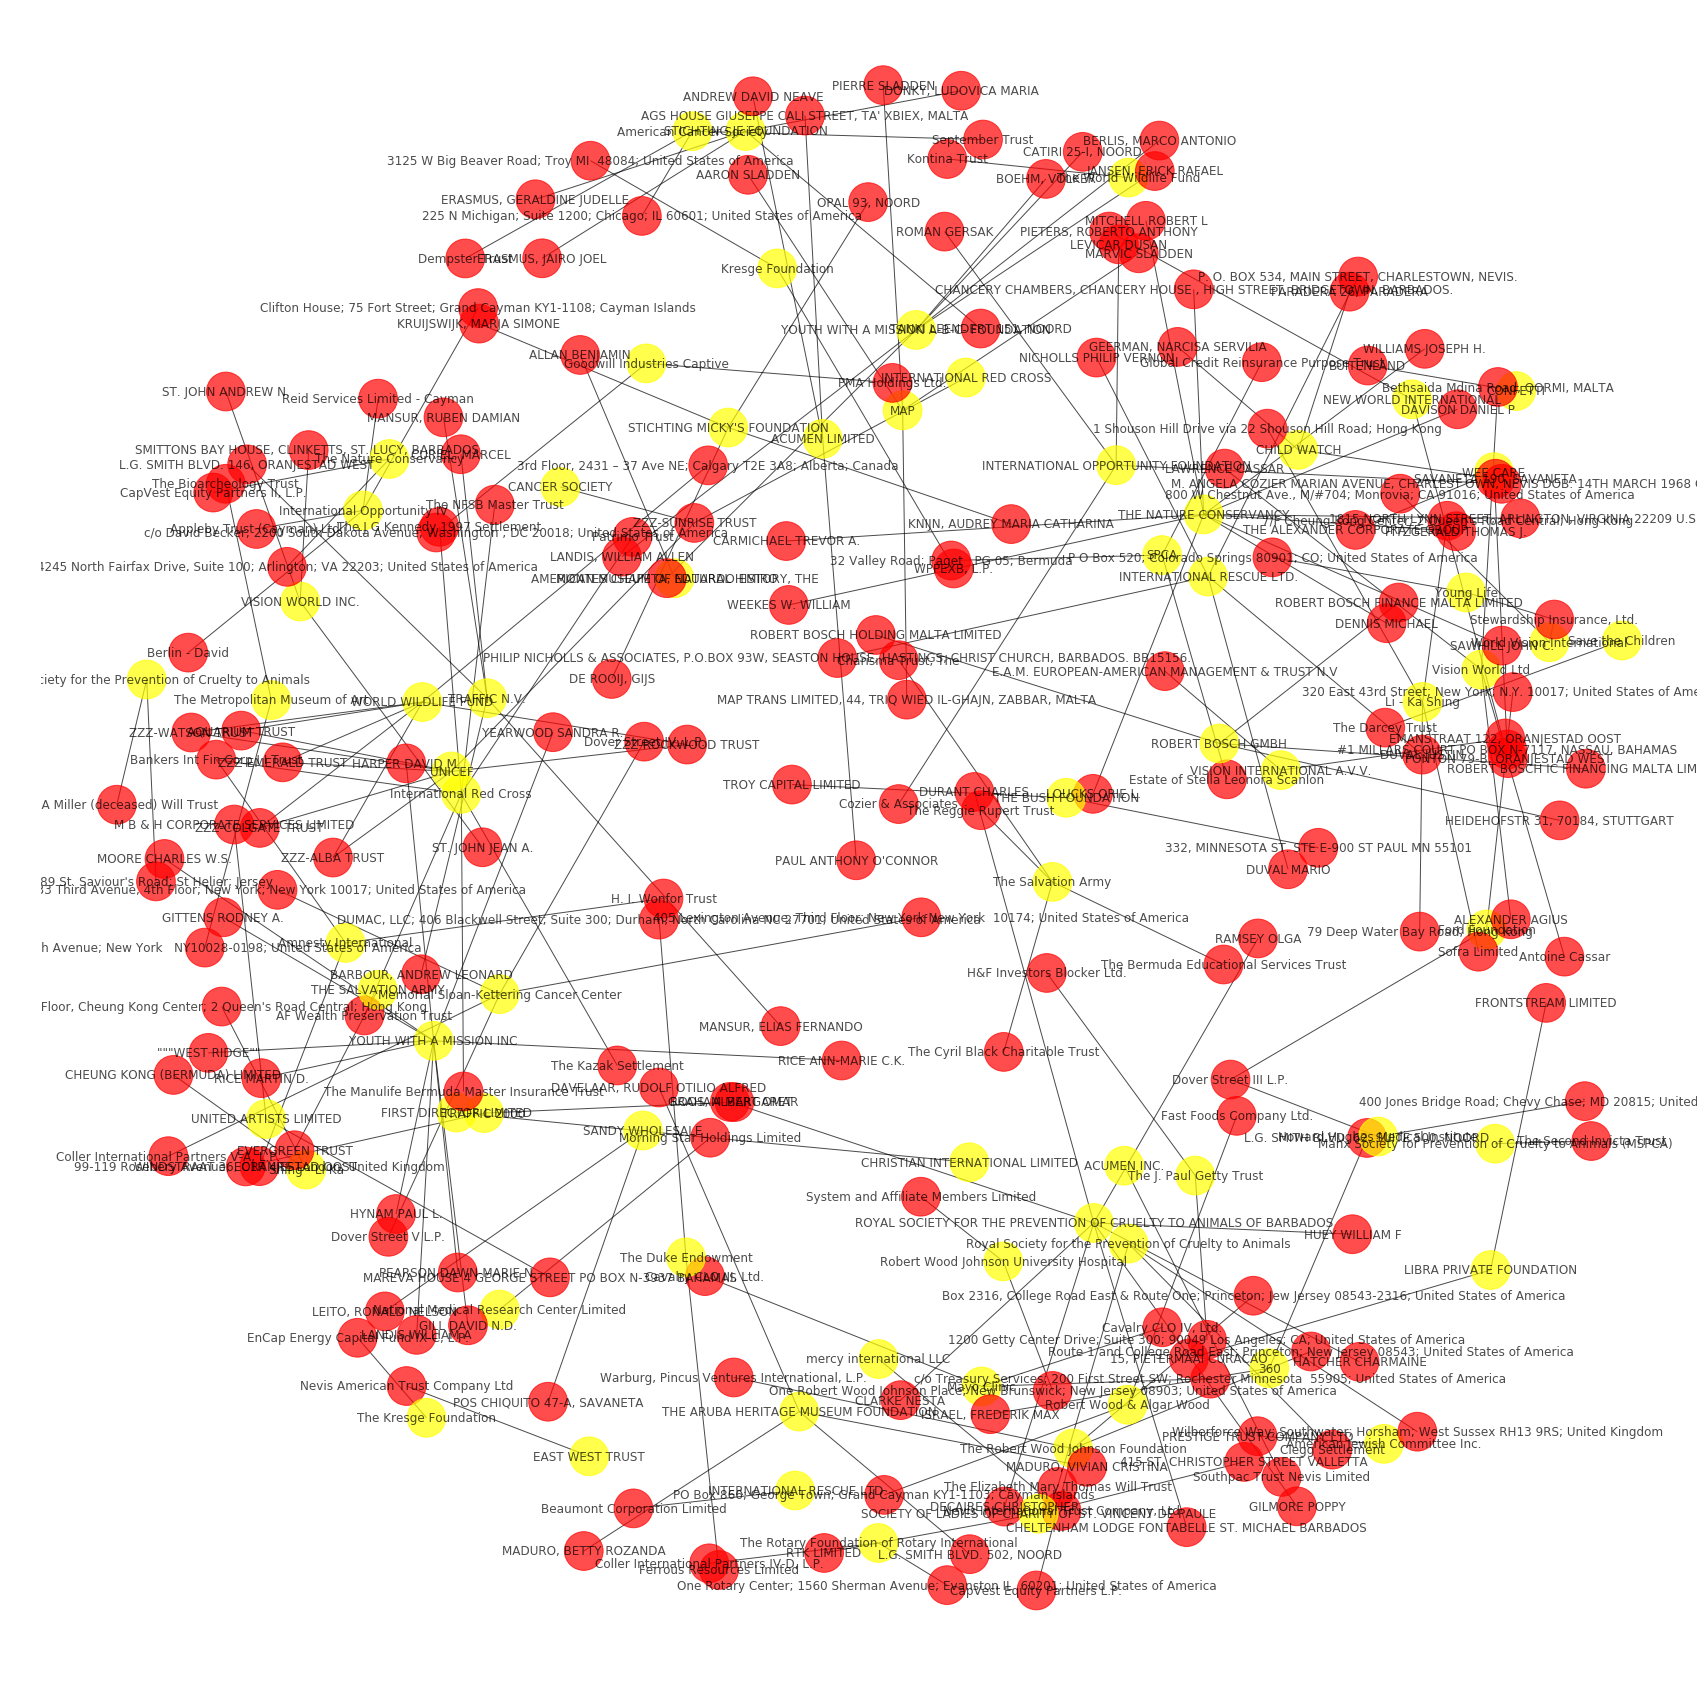

In [64]:
graph_leak_matches('paradise')

 This graph is much too large for us to handle, so we filter it down, removing any non-charity nodes that are only connected to one other node (an therefore aren't connecting anyone).

Size before removing loners: 234
Size after removing loners: 57
Matches for paradise papers: 
Name: 
Type: Graph
Number of nodes: 39
Number of edges: 34
Average degree:   1.7436
Yellow: "Charities" / Red: "Connectors"


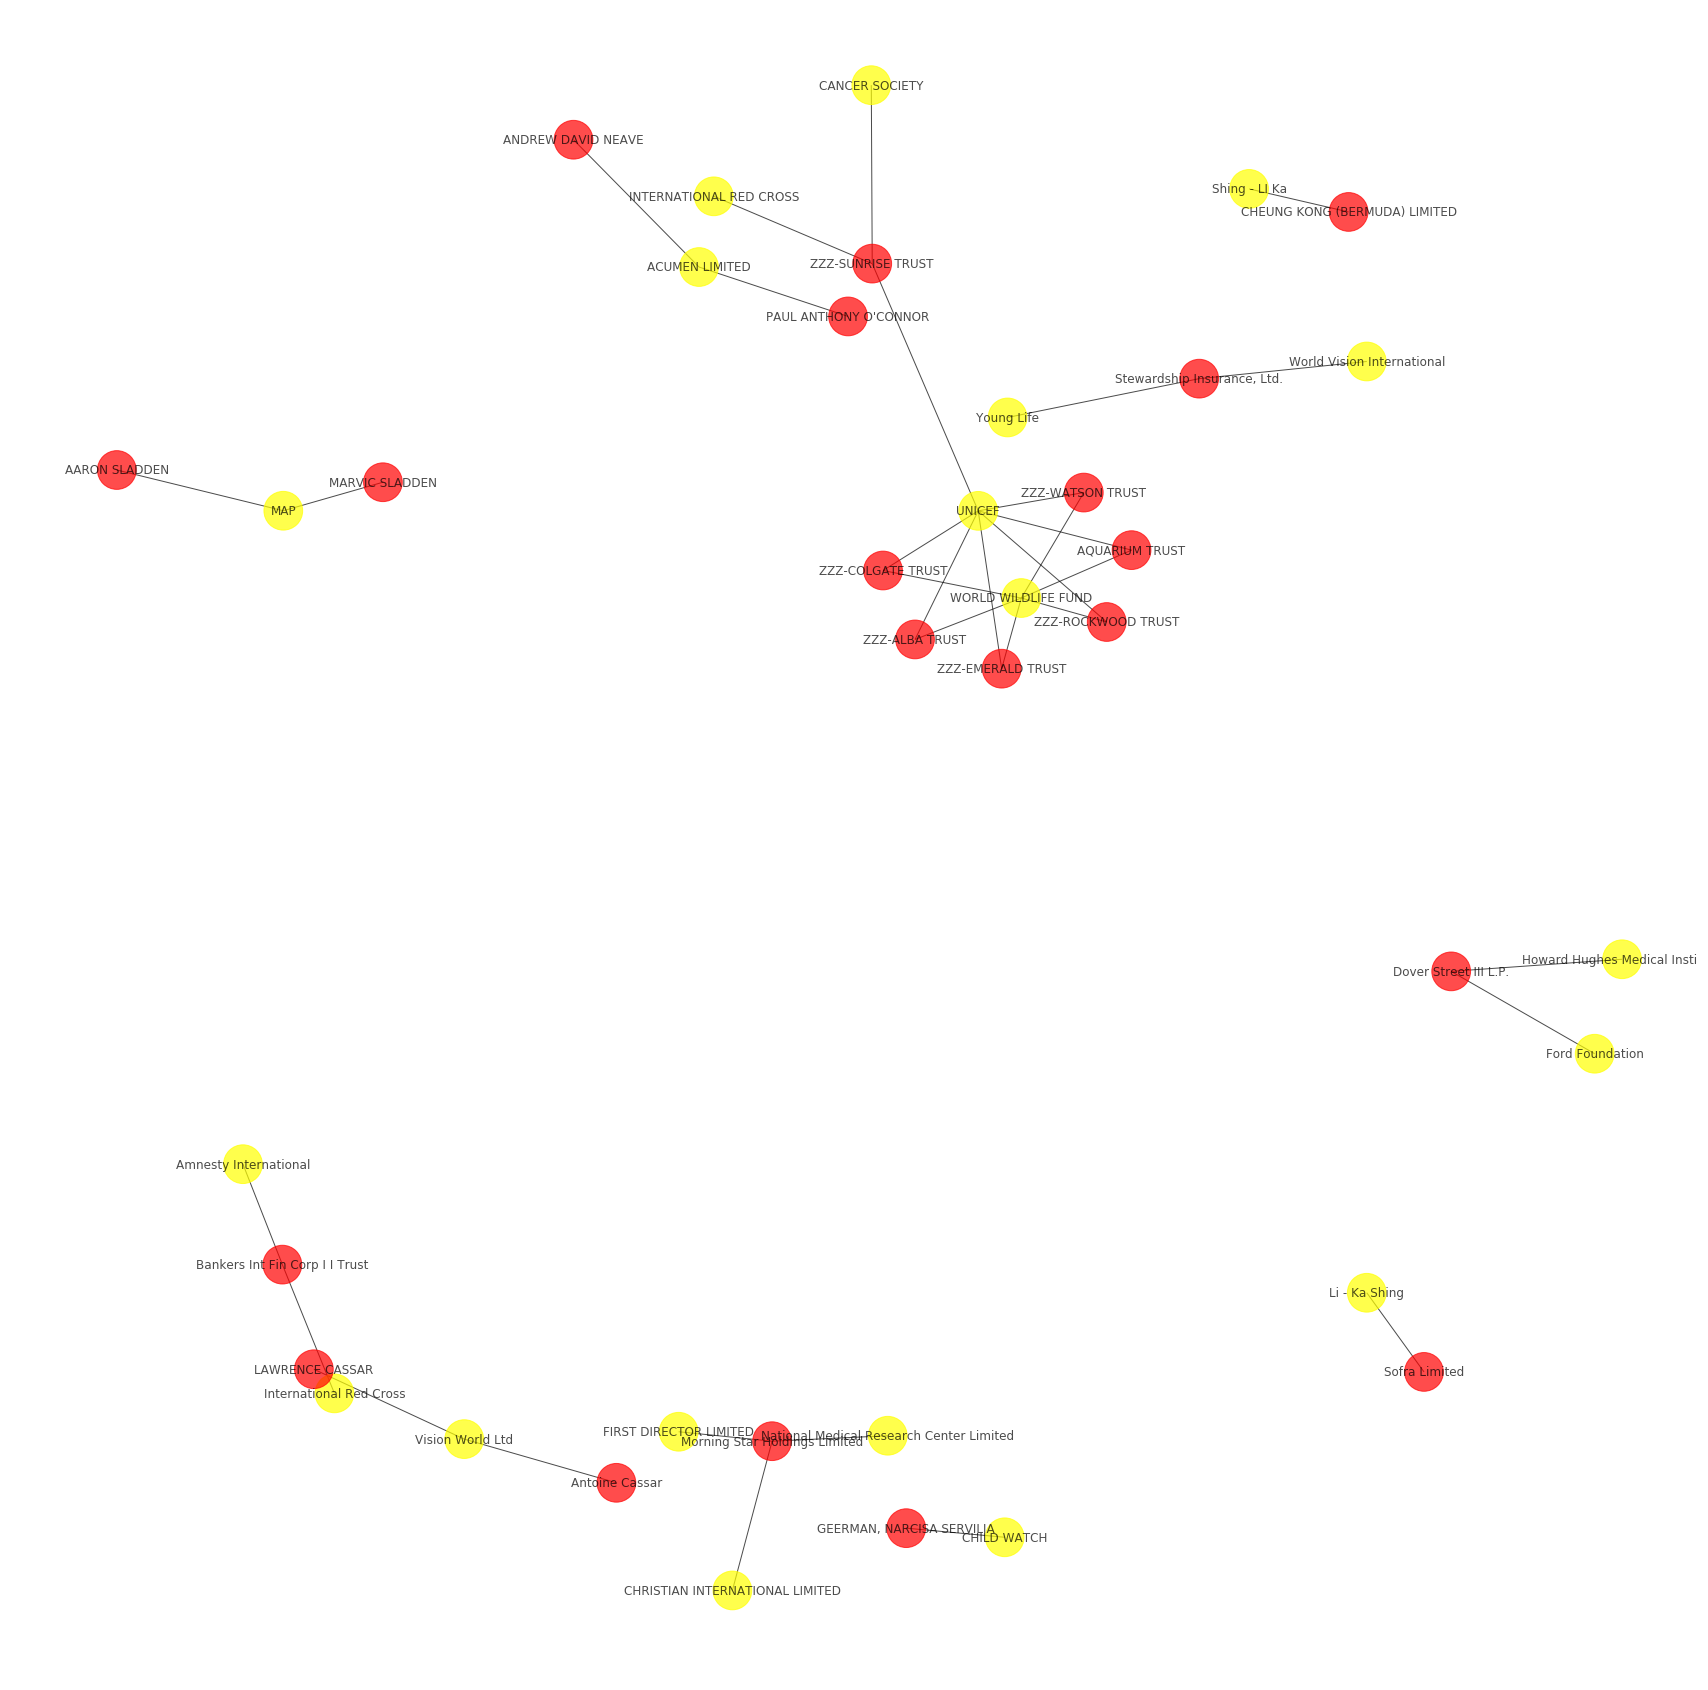

In [66]:
graph_leak_matches('paradise', True)

We now have a much clearer image of the connecting nodes, and we notice several things.

First, UNICEF and the World Wildlife Fund are back, but this time they are connected to the "Internation Red Cross", which the real Red Cross insists is a fake (https://www.icrc.org/en/document/misuse-icrcs-identity-panama-papers, https://www.reuters.com/article/us-panama-tax-charities-idUSKCN0X828W). This is a strong argument for UNICEF and the World Wildlife Fund also being stolen names (same thing for the Cancer society, which is also in this cluster).

Notably, this cluster is not the only place where the "International Red Cross" shows up, suggesting multiple different nodes have this name, which reinforces the idea that the name is stolen. In the second, smaller cluster, we also find Amnesty International, which therefore can also be considered a victim of name theft.

Matches for offshore papers: 
Name: 
Type: Graph
Number of nodes: 94
Number of edges: 84
Average degree:   1.7872
Yellow: "Charities" / Red: "Connectors"


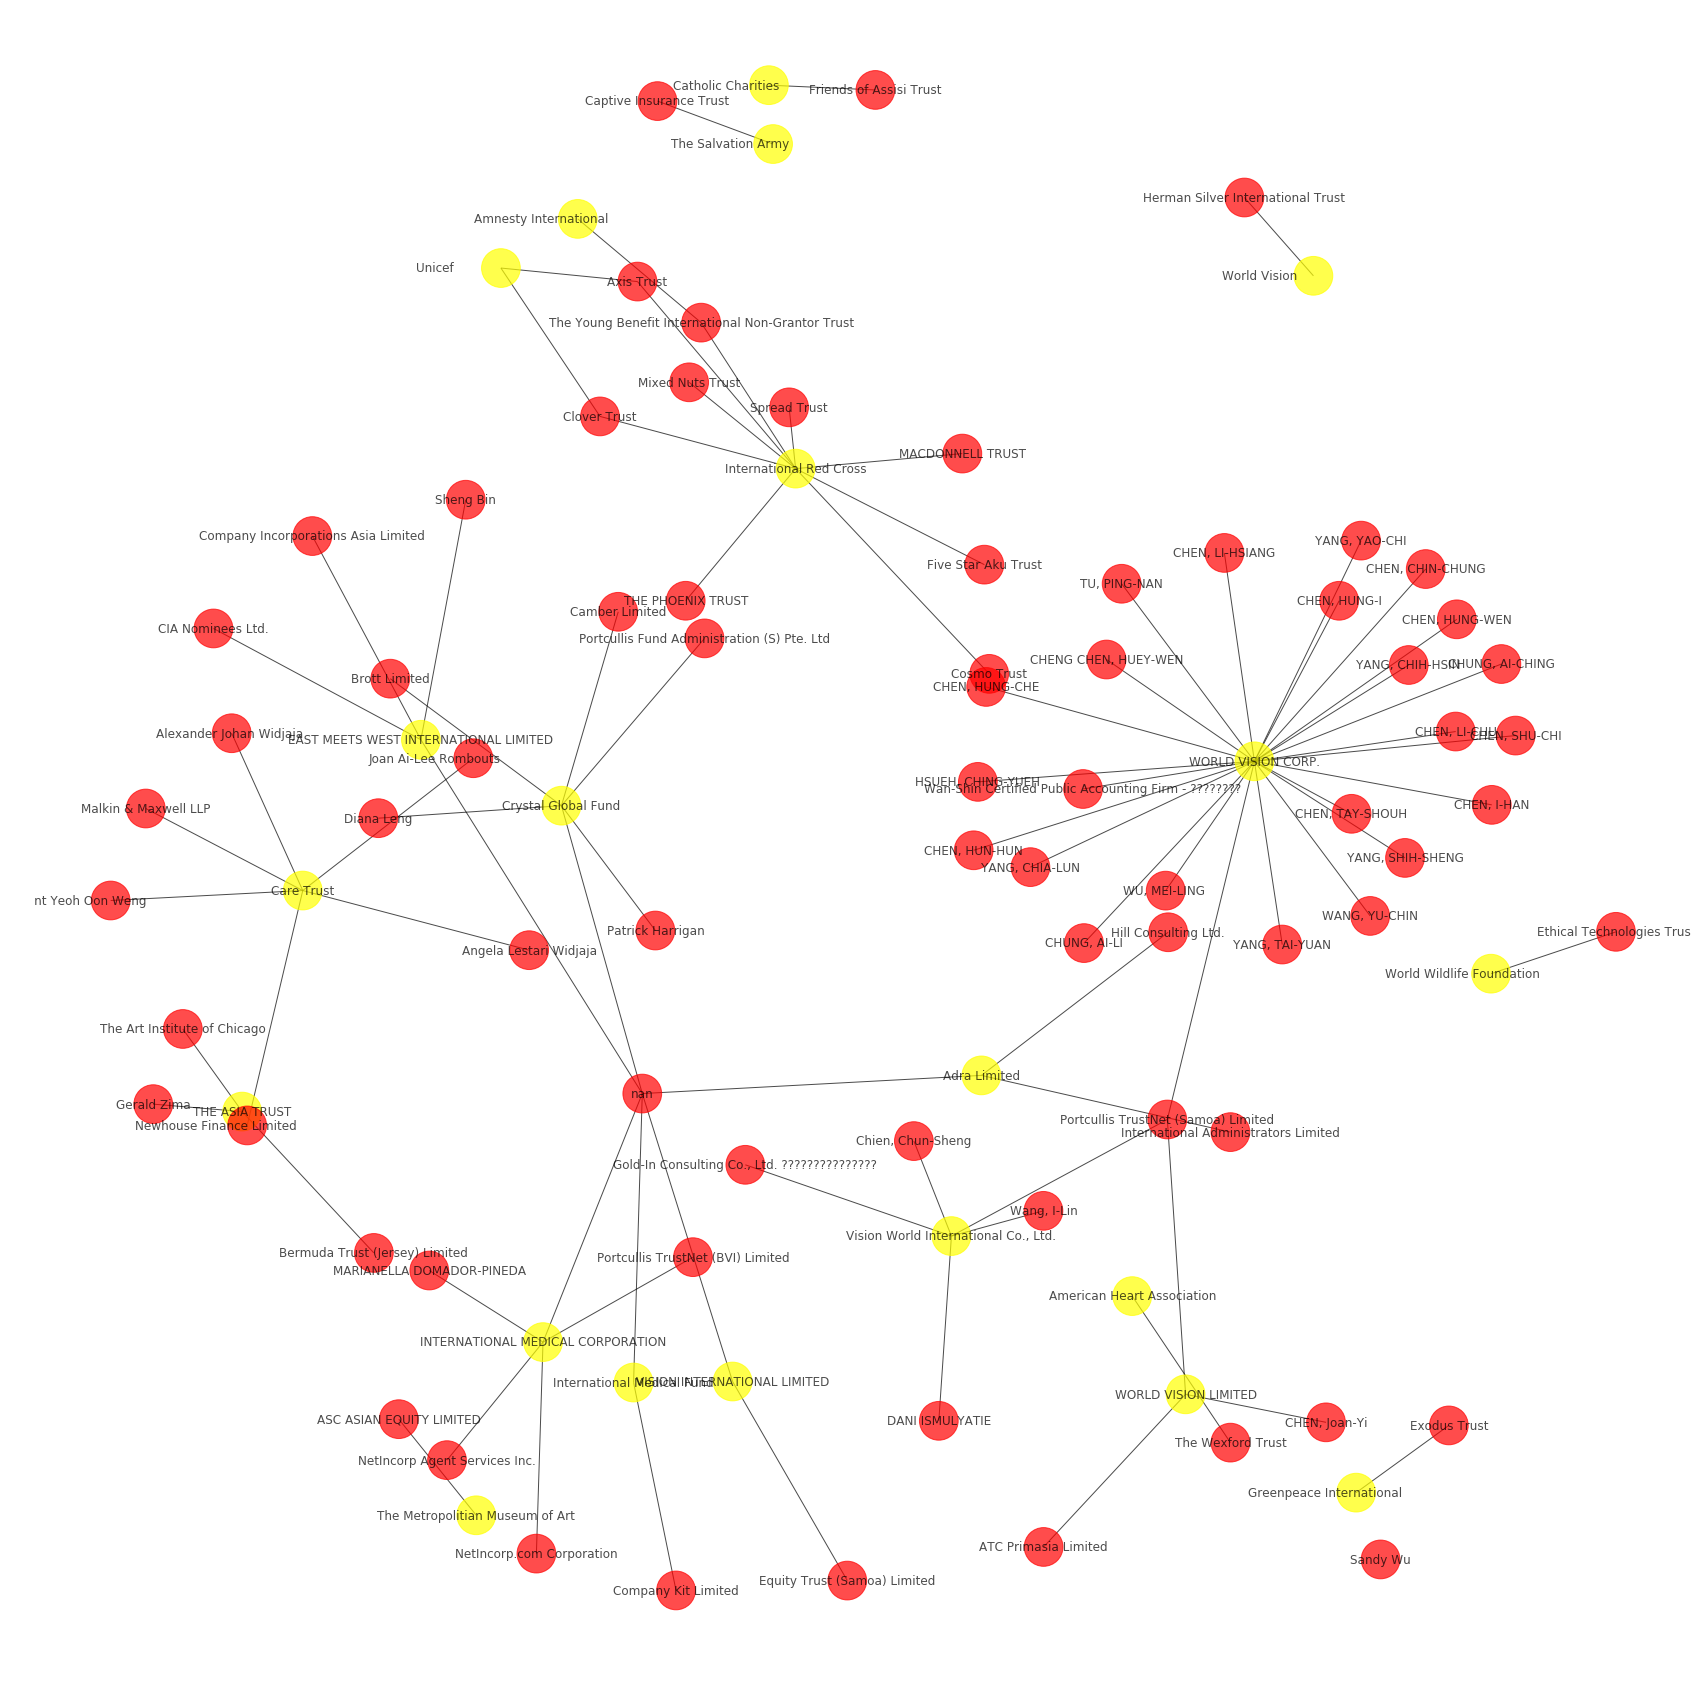

In [70]:
graph_leak_matches('offshore')

This graph is also very nice. We find again the "International Red Cross" and "Amnesty International" (and also "UNICEF"!), this time connected through a different intermediary. Clearly, there is more than one company out there ripping off the names of famous charities.

Matches for bahamas papers: 
Name: 
Type: Graph
Number of nodes: 43
Number of edges: 26
Average degree:   1.2093
Yellow: "Charities" / Red: "Connectors"


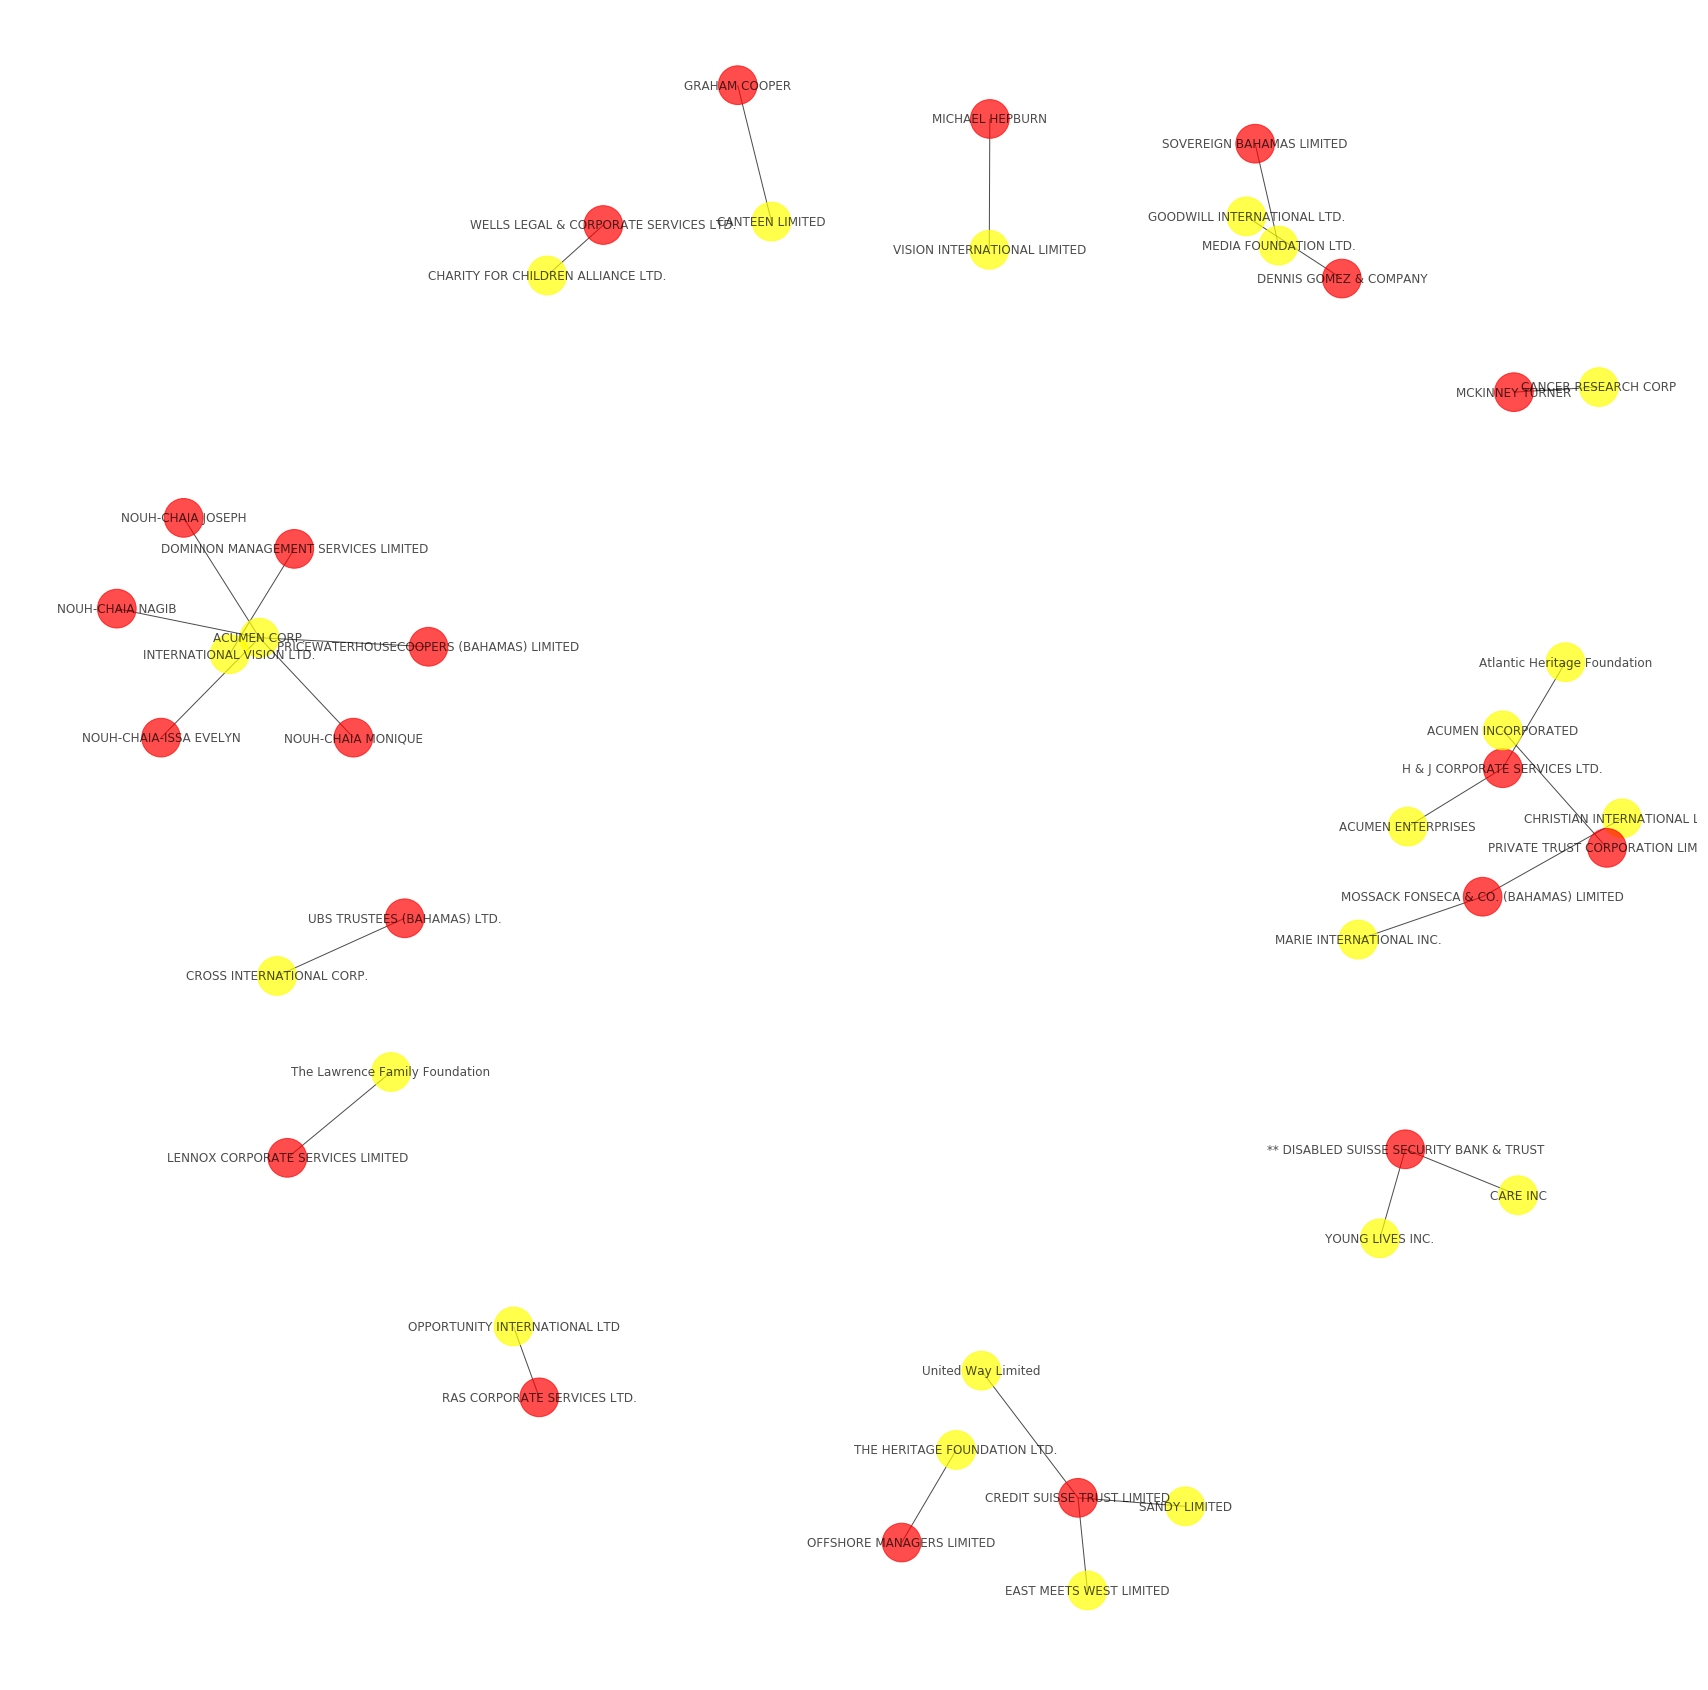

In [71]:
graph_leak_matches('bahamas')

While they lack the big charity names of the previous leaks, the bahamas papers nevertheless contain some information that is particularly relevant in Switzerland. Indeed, there is a cluster of three charities, United Way, Sandy and East Meets West, where the central nodes is...Credit Suisse, the second largest bank in Switzerland. A bit of research tells us that this is probably the real bank: Credit Suisse is listed as the third largest faciliator for offshore accounts in the Panama Papers, and together with UBS is responsible for one in ten of all trusts leaked in the Bahamas Papers. (https://www.swissinfo.ch/eng/streamlining-_credit-suisse-to-close-panama-private-banking-office/42192864)  (https://www.swissinfo.ch/eng/streamlining-_credit-suisse-to-close-panama-private-banking-office/42192864)

Our conclusion to this research is therefore the following: always do some research before donating to charities, and also before opening a bank account!